
Bayesian Optimization helps to find a best model among many. We have cross-validation in hand. But how many samples we gonna try on a pre-list to choose a best model among them. That’s why Bayesian approach speed up the process by reducing the computation task and doesn’t expect help from the person to guess the values. This optimization technique is based on randomness and probability distributions.

Source:
1. https://arxiv.org/pdf/1807.02811.pdf
2. https://towardsdatascience.com/shallow-understanding-on-bayesian-optimization-324b6c1f7083
3. http://krasserm.github.io/2018/03/21/bayesian-optimization/
4. https://www.youtube.com/watch?v=vz3D36VXefI

Let's assume a known function:
$$ -sin(3X) - X^2 + 0.7X $$

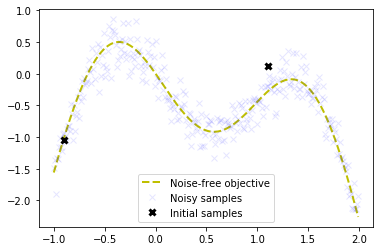

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)



# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

Our goal here is not to determine the objective function(which is unknow) as a curve completely with as much as observed points as possible. Instead, we need the arg of the maximum value(index of the max function).

### Acquisition function: Probability of Improvement


Goal is to find the global optimum on the left in a small number of steps. The next step is to implement the acquisition function defined as expected_improvement function. 

$$ PI(x)=\Phi (\frac{\mu(x)-\mu^{+}-\xi}{\sigma(x)})$$

Where $\mu^{+}$ is the best observed value among the past points, among our past observation, the next possible max value $\mu(x)$ should be larger than the current max observed value $\mu^{+}$. $\xi$ is a very small arbitary value, preventing the algorithm finds the current value as the next possible max value.

If we look into the code we will find that the fuction is performing a exploration and exploitation choice. $\mu(x)-\mu^{+}-\xi$ is finding the maximum value, while $\sigma$ in the denumerator, is making sure that the uncertainty is not too large.

In [2]:
from scipy.stats import norm

def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    ''' Computes the EI at points X based on existing samples X_sample and Y_sample using a Gaussian process surrogate model. Args: X: Points at which EI shall be computed (m x d). X_sample: Sample locations (n x d). Y_sample: Sample values (n x 1). gpr: A GaussianProcessRegressor fitted to samples. xi: Exploitation-exploration trade-off parameter. Returns: Expected improvements at points X. '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, X_sample.shape[1])
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [...]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

### Our Goal 


Our next chosen point( x ) should have high mean (exploitation) & high variance (exploration).

Selecting high expected values means we chose the next point $x$ with high offset so that we should give some exploitation weights to decrease the mean of the next point.
Yet we should not ignore the exploration, where we have to search for the point with high variance distribution. 

In [3]:
from scipy.optimize import minimize

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    ''' Proposes the next sampling point by optimizing the acquisition function. Args: acquisition: Acquisition function. X_sample: Sample locations (n x d). Y_sample: Sample values (n x 1). gpr: A GaussianProcessRegressor fitted to samples. Returns: Location of the acquisition function maximum. '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

tools for plotting

In [4]:
def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    plt.plot(X, Y, 'y--', lw=1, label='Noise-free objective')
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    
        
def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x)+1)
    
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.maximum.accumulate(y)
    
    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, 'bo-')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')

    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, 'ro-')
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')       

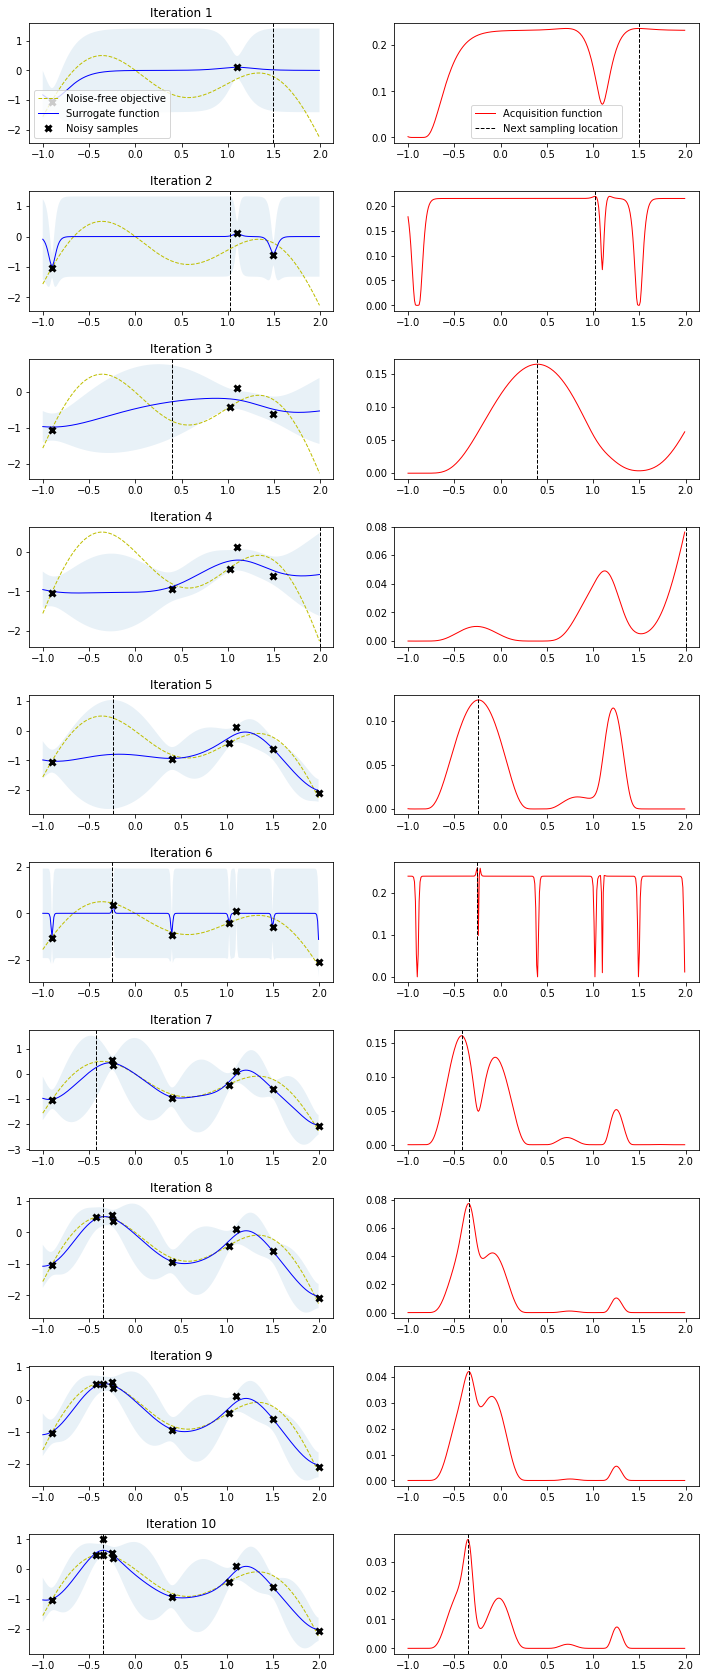

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
# from bayesian_optimization_util import plot_approximation, plot_acquisition

# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

In [6]:
### Scykit learn implementation

In [7]:
#re state all the required data
import numpy as np
#1. 
bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)



# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

C:\Users\atseng17\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


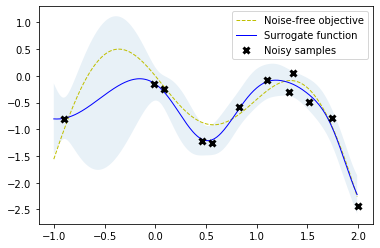

In [8]:
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern
import matplotlib.pyplot as plt

%matplotlib inline
# Use custom kernel and estimator to match previous example
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

r = gp_minimize(lambda x: -f(np.array(x))[0], 
                bounds.tolist(),
                base_estimator=gpr,
                acq_func='EI',      # expected improvement
                xi=0.01,            # exploitation-exploration trade-off
                n_calls=10,         # number of iterations
                n_random_starts=0,  # initial samples are provided
                x0=X_init.tolist(), # initial samples
                y0=-Y_init.ravel())

# Fit GP model to samples for plotting results
gpr.fit(r.x_iters, -r.func_vals)

# Plot the fitted model and the noisy samples
plot_approximation(gpr, X, Y, r.x_iters, -r.func_vals, show_legend=True)

### Application of Baysian method on hyperparameter tuning

In [10]:
from sklearn import datasets
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

from scipy.stats import uniform
from xgboost import XGBRegressor

# Load the diabetes dataset (for regression)
X, Y = datasets.load_diabetes(return_X_y=True)

# Instantiate an XGBRegressor with default hyperparameter settings
xgb = XGBRegressor()

# and compute a baseline to beat with hyperparameter optimization 
baseline = cross_val_score(xgb, X, Y, scoring='neg_mean_squared_error').mean()

C:\Users\atseng17\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[12:25:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Let's use random search for cross validation

In [11]:

# Hyperparameters to tune and their ranges
param_dist = {"learning_rate": uniform(0, 1),
              "gamma": uniform(0, 5),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10)}

rs = RandomizedSearchCV(xgb, param_distributions=param_dist, 
                        scoring='neg_mean_squared_error', n_iter=25)

# Run random search for 25 iterations
rs.fit(X, Y);

C:\Users\atseng17\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[12:25:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:29] WARNI

[12:25:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:25:44] WARNI

C:\Users\atseng17\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Now let's use baysian optimization for tunign the hyperparameters.

In [15]:
from GPyOpt.methods import BayesianOptimization
bds = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
        {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
        {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 300)},
        {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}]

# Optimization objective 
def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(
                XGBRegressor(learning_rate=parameters[0],
                              gamma=int(parameters[1]),
                              max_depth=int(parameters[2]),
                              n_estimators=int(parameters[3]),
                              min_child_weight = parameters[4]), 
                X, Y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

optimizer = BayesianOptimization(f=cv_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.05,
                                 exact_feval=True, 
                                 maximize=True)

# Only 20 iterations because we have 5 initial random points
optimizer.run_optimization(max_iter=20)

[12:29:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:15] WARNI

[12:29:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:38] WARNI

Baseline neg. MSE = -3498.95
Random search neg. MSE = -3639.63
Bayesian optimization neg. MSE = -3279.30


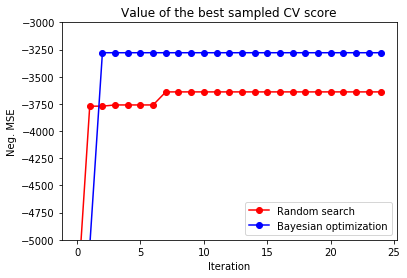

In [16]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

print(f'Baseline neg. MSE = {baseline:.2f}')
print(f'Random search neg. MSE = {y_rs[-1]:.2f}')
print(f'Bayesian optimization neg. MSE = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
plt.ylim(-5000, -3000)
plt.title('Value of the best sampled CV score');
plt.legend();